In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import IPython.display
import pickle
import os
from tqdm import tqdm
import collections
import json
import torch
import torch.nn.functional as F
import sys
import numpy as np


sys.path.append('..')
from src.train import Trainer
from src.utils import set_requires_grad
from src.clsmodel import mnist, stl10

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def get_transparent_cmap(cmap):
    # get colormap
    ncolors = 256
    color_array = plt.get_cmap(cmap)(range(ncolors))

    # change alpha values
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name=cmap, colors=color_array)


    return map_object

INFO: Using numpy backend


In [2]:
# load exp config
model_path = '/vol/biomedic2/agk21/PhDLogs/codes/SYB3/logs/MNIST/models/best.pth'

#data-folder-path
folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/MorphoMNISTv0/IT/data'

config = json.load(open(os.path.join(os.path.dirname(os.path.dirname(model_path)), 'exp-config.json'), 'r'))

config['classifier'] = mnist(32, 'ti').cuda(0)
model = Trainer(**config)
model.load_model(model_path)
model.eval()


# model defns
feature_extractor = model.feature_extractor
conti_classifier = model.classifier_baseline
dis_classifier = model.classifier_quantized
decoder = model.dec
codebook_sampler = model.modelclass


# set_requires_grad(classifier, False)
set_requires_grad(feature_extractor, False)
set_requires_grad(conti_classifier, False)
set_requires_grad(dis_classifier, False)
set_requires_grad(decoder, False)
set_requires_grad(codebook_sampler, False)
    

# required config variables 
image_size = model.input_size
latent_dim = model.latent_size
num_classes = model.nclasses

Building STL10 data loader with 16 workers
True
3 2 2 2
FeatureExtractor: Total number of trainable params: 0/28640
ContiClassifier: Total number of trainable params: 0/10250
codebook: Total number of trainable params: 35817/35817
DisClassifier: Total number of trainable params: 330/330
Decoder: Total number of trainable params: 7141443/7141443
Model loaded from /vol/biomedic2/agk21/PhDLogs/codes/SYB3/logs/MNIST/models/best.pth, loaded epoch:1 with stats: {'loss': 1.8621094, 'f1': 0.9816000000000001, 'acc': 0.9816000000000001, 'rloss': 0.01574749}


In [18]:
from src.dataset import get

batch_size = 16
train_loader, test_loader = get(batch_size, 
                      data_root = folder_path, 
                      train=True, val=True, 
                      input_size = image_size,
                      num_workers=10)


orig_images = []; orig_labels = []
for (img_batch, label_batch, *context_batch) in tqdm(test_loader):
    img_batch = img_batch.cuda(0)
    label_batch = label_batch.cuda(0)
    orig_images.extend(img_batch)
    orig_labels.extend(label_batch)


labels_ = np.array([lb.cpu().numpy() for lb in orig_labels])
# generate sample dataset
def get_sample_data(N_datapoints = 10): 
    sample_images = []; sample_labels = []
    for ci in range(num_classes):
        idxs = np.where(labels_ == ci)[0]
        randidxs = idxs[np.random.randint(0, len(idxs), N_datapoints//num_classes)]

        for idx in randidxs:
            sample_images.append(orig_images[idx].unsqueeze(0))
            sample_labels.append(orig_labels[idx].unsqueeze(0))

    sample_images = torch.cat(sample_images, dim = 0)
    sample_labels = torch.cat(sample_labels, dim = 0)
    return sample_images, sample_labels

Building STL10 data loader with 10 workers


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:03<00:00, 175.98it/s]


508


101it [00:09, 11.19it/s]


141


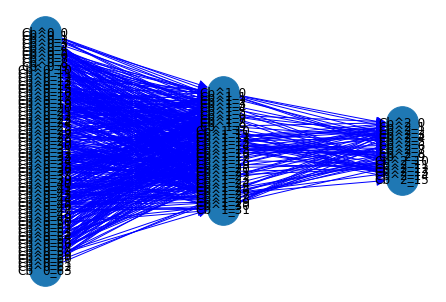

In [28]:
from src.inference import InductiveReasoningDT

inferer = InductiveReasoningDT(get_sample_data(100),
                               ncodebook_features = model.codebook_size,
                               nclasses = num_classes,
                               train_loader = train_loader,
                               feature_extractor = feature_extractor,
                               codebook = codebook_sampler,
                               classifier = dis_classifier,
                               decoder = decoder)

                               

In [5]:
codebook_sampler.reasoningLayers[0].weight

Parameter containing:
tensor([[0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], device='cuda:0')

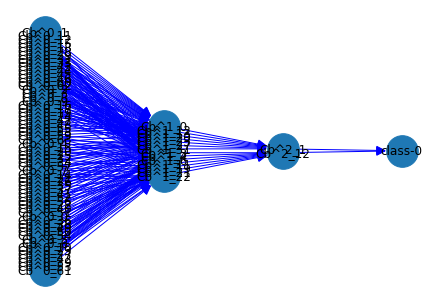

In [10]:
inferer.get_class_tree(0)

In [15]:
x,y = get_sample_data(10)
x = x[:1]

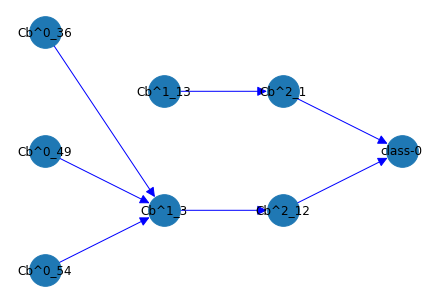

In [16]:
inferer.get_local_tree(0, x)

*************** Level-0 heirarchy **************
class-0 <- Cb^2_1,Cb^2_12


<Figure size 432x288 with 0 Axes>

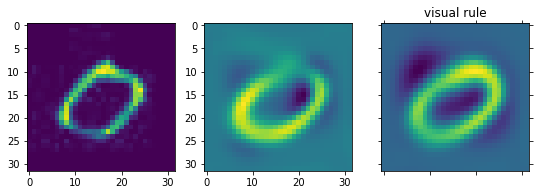

*************** Level-1 heirarchy **************
Cb^2_1 <- Cb^1_13


<Figure size 432x288 with 0 Axes>

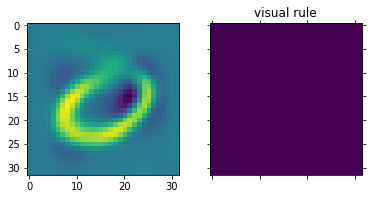

Cb^2_12 <- Cb^1_3


<Figure size 432x288 with 0 Axes>

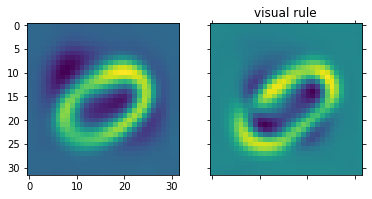

*************** Level-2 heirarchy **************
Cb^1_3 <- Cb^0_36,Cb^0_49,Cb^0_54


<Figure size 432x288 with 0 Axes>

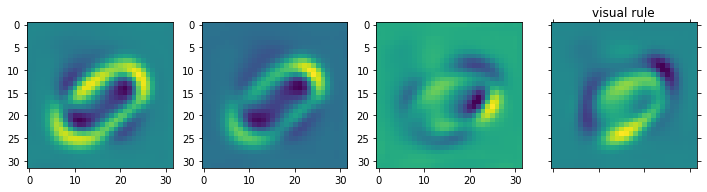

[['class-0 <- Cb^2_1,Cb^2_12'],
 ['Cb^2_1 <- Cb^1_13', 'Cb^2_12 <- Cb^1_3'],
 ['Cb^1_3 <- Cb^0_36,Cb^0_49,Cb^0_54']]

In [17]:
inferer.query(0, visual = x, local=True)